## IMPORTS

In [ ]:
import pandas as pd
import sys
from matplotlib import pyplot as plt
import pickle
import os
from collections import OrderedDict

sys.path.append('../../')
from utils import clustering_utils, bokeh_ui_utils_final, file_utils, expr_data_utils

In [ ]:
palette65 = """
white\ngainsboro\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

In [ ]:
phases_dict = OrderedDict([('full', None), ('veg', None), ('sex', None)])

metric = 'manhattan'
# metric='minkowski_3.0'

resolution_param=0.005
# resolution_param=0.0001

n_neighbors = 3

dataset = 'microarray'

add_scalar=0

In [ ]:
full_filtered_df = pd.read_csv('../microarray_probe_alignment_and_filtering/allgood_filt_agg_tidy_2021aligned_qc_rma_expression_full.csv')
full_filtered_df = full_filtered_df.rename(columns={'Unnamed: 0': 'TTHERM_ID'})
phases_dict['full'] = full_filtered_df

veg_cols = [col for col in full_filtered_df.columns if col[0] != 'C']
veg_filtered_df = full_filtered_df.loc[:, veg_cols]
phases_dict['veg'] = veg_filtered_df

sex_cols = [col for col in full_filtered_df.columns if col[0] == 'C']
sex_filtered_df = full_filtered_df.loc[:, ['TTHERM_ID'] + sex_cols]
phases_dict['sex'] = sex_filtered_df

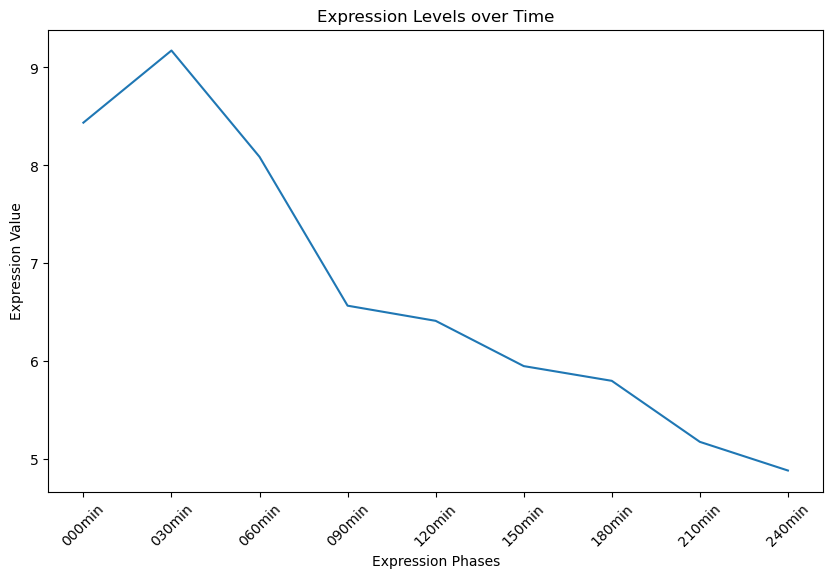

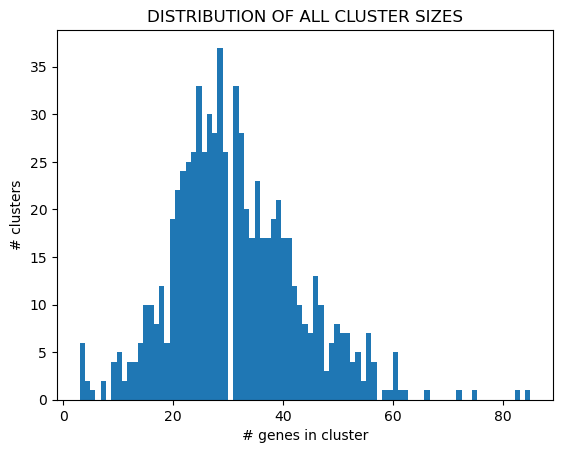

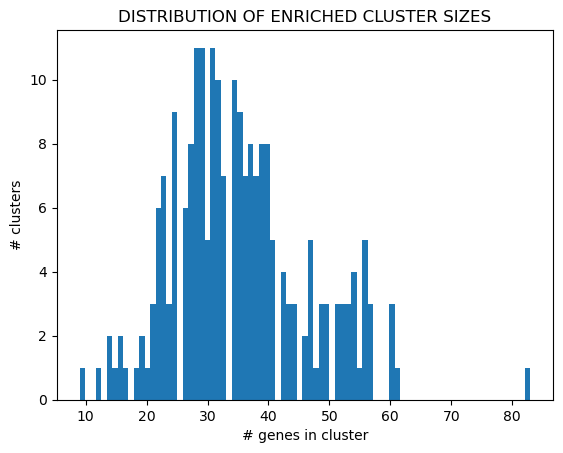

              partition_type: EXP
              dimensionality: baseline
                      metric: manhattan
                       graph: umap_fuzzy_simplicial_set
                         nns: 3
                  clustering: leiden_cpm
                   parameter: 0.005
            silhouette_score: -0.04485206694104344
                  modularity: 0.7949152804762321
                   nclusters: 734
           mean_cluster_size: 31.48773841961853
         median_cluster_size: 30.0
             sd_cluster_size: 11.62067297489011
          nenriched_clusters: 222
  mean_enriched_cluster_size: 35.153153153153156
median_enriched_cluster_size: 34.0
    sd_enriched_cluster_size: 11.106931686972178
     nenriched_cluster_genes: 7804
                    datetime: 2024-07-02 15:12:49.896934


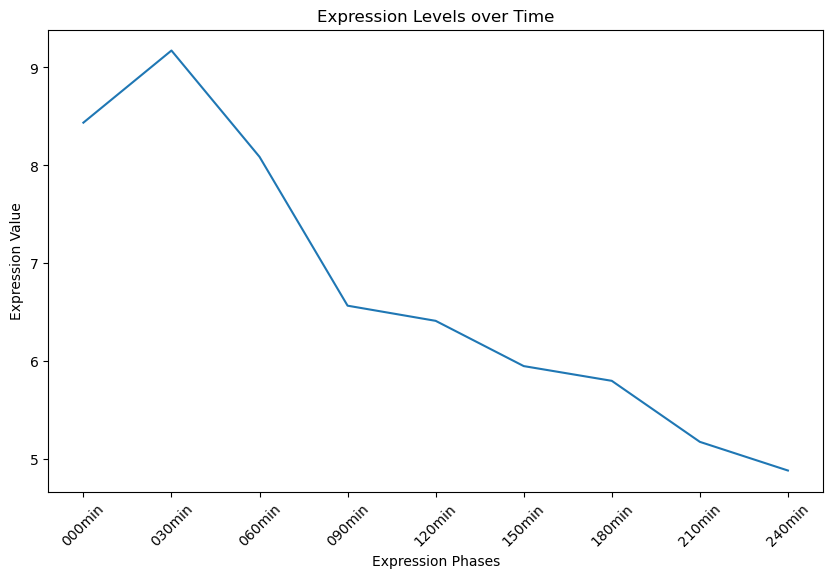

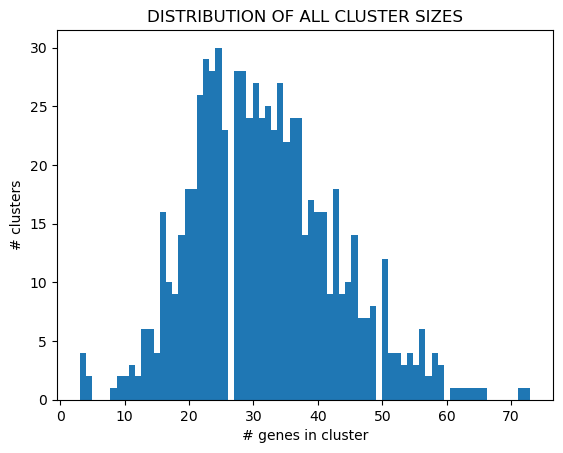

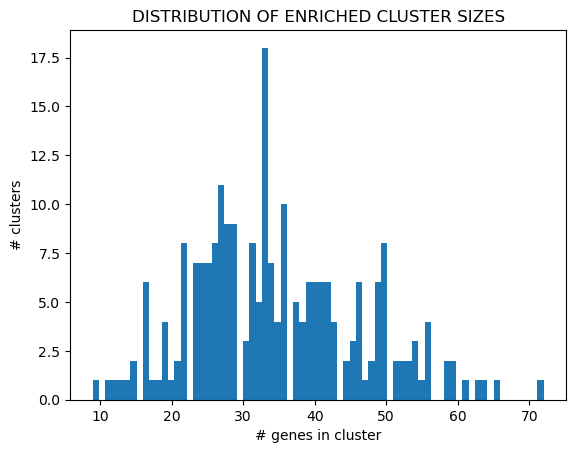

              partition_type: EXP
              dimensionality: baseline
                      metric: manhattan
                       graph: umap_fuzzy_simplicial_set
                         nns: 3
                  clustering: leiden_cpm
                   parameter: 0.005
            silhouette_score: -0.038662862962688546
                  modularity: 0.7896361710744539
                   nclusters: 727
           mean_cluster_size: 31.79092159559835
         median_cluster_size: 31.0
             sd_cluster_size: 11.173030759136452
          nenriched_clusters: 231
  mean_enriched_cluster_size: 34.696969696969695
median_enriched_cluster_size: 33.0
    sd_enriched_cluster_size: 11.72276947442868
     nenriched_cluster_genes: 8015
                    datetime: 2024-07-02 15:14:18.554981


In [ ]:
for phases, curr_df in phases_dict.items():
    data_dict = {
                    'expression_dfs':   [
                                        expr_data_utils.mean_df_of_duplicates(
                                            expr_data_utils.normalize_expression_per_gene(curr_df, 'z_score', add_scalar=add_scalar), mean_type='arithmetic'), 
                                        expr_data_utils.mean_df_of_duplicates(
                                            expr_data_utils.normalize_expression_per_gene(curr_df, 'min_max', add_scalar=add_scalar), mean_type='arithmetic')
                                        ],
                    'tab_labels': ['z_score', 'min_max'],
                    'expr_mins': [-3, 0],
                    'expr_maxs': [3, 1],
                    'label_dfs': [],
                    'enrich_dfs': [],
                    'avg_dfs': [],
                    'color_palettes': []
                }

    for full_filtered_norm_df in data_dict['expression_dfs']:

        num_genes = curr_df.shape[0]

        df = expr_data_utils.mean_df_of_duplicates(curr_df.loc[curr_df['TTHERM_ID'] == 'TTHERM_00092820'], mean_type='arithmetic')

        phase_list = list(df.columns)[1:]
        expression_values = [df[col].values[0] for col in list(df.columns)[1:]]

        plt.figure(figsize=(10, 6))  

        plt.plot(phase_list, expression_values, linestyle='-')

        plt.xlabel("Expression Phases")
        plt.ylabel("Expression Value")
        plt.title("Expression Levels over Time")

        plt.xticks(rotation=45)

        plt.show()

        full_filtered_norm_df.head()
        leiden_label_df_round_1, partition_stats, cluster_sizes, enriched_cluster_sizes =  clustering_utils.build_label_df(
            full_filtered_norm_df, 
            dataset,
            metric=metric, 
            n_neighbors=n_neighbors, 
            resolution_param=resolution_param, 
            partition_type = 'EXP', 
            n_jobs = -1, 
            random_state=42
            )
        leiden_label_df_round_1_arranged = bokeh_ui_utils_final.arrange_modules(full_filtered_norm_df, leiden_label_df_round_1, phases) 
        leiden_label_df_round_1_arranged_sorted = leiden_label_df_round_1_arranged.sort_values(by=['label', 'TTHERM_ID'], ascending=False)
        leiden_label_df_round_1_arranged_sorted.to_csv('./test_nn3_leiden_label_df_round_1.csv', index=False)
        avg_full_filtered_norm_df = clustering_utils.ari_mean_nexpr_per_mod(full_filtered_norm_df, leiden_label_df_round_1_arranged_sorted)
        plt.hist(cluster_sizes, max(cluster_sizes))
        plt.title('DISTRIBUTION OF ALL CLUSTER SIZES')
        plt.xlabel('# genes in cluster')
        plt.ylabel('# clusters')
        plt.show()
        plt.hist(enriched_cluster_sizes, max(enriched_cluster_sizes))
        plt.title('DISTRIBUTION OF ENRICHED CLUSTER SIZES')
        plt.xlabel('# genes in cluster')
        plt.ylabel('# clusters')
        plt.show()
        key_lens = [len(k) for k in partition_stats.keys()]
        max_key_len = max(key_lens)

        for k, v in partition_stats.items():
            print(f'{" " * (max_key_len - len(k))}{k}:', v)
        enrich_full_nn3 = clustering_utils.compute_enrichment(leiden_label_df_round_1_arranged_sorted)
        outfile='../enrichment/test_nn3_full_enrichment.csv'
        enrich_full_nn3.to_csv(outfile, index=False)
        complete_annot = pd.read_csv('../eggnog/complete_eggnog_annotation.csv')

        data_dict['label_dfs'].append(leiden_label_df_round_1_arranged_sorted)
        data_dict['enrich_dfs'].append(enrich_full_nn3)
        data_dict['avg_dfs'].append(avg_full_filtered_norm_df)



    with open(('colors_2000_1'), 'rb') as file:
        color_palette_raw = pickle.load(file)

    for _df in data_dict['label_dfs']:
        color_palette = palette65

        if len(color_palette_raw) >= max(_df['label'].unique()) + 1:
            color_palette = color_palette_raw[: max(_df['label'].unique()) + 1]

        data_dict['color_palettes'].append(color_palette)

    yf_to_ttherm_map_df = None

    embedding_metric = 'manhattan'

    dashboard_path = file_utils.generate_uniquely_numbered_export_path('./plots/', 'dashboard', '.html', tags=[dataset, 'umap', metric, f'{n_neighbors}nn', f'{resolution_param}rp'])

    p = bokeh_ui_utils_final.generate_and_save_umap_tabbed(
                                                    dashboard_path, 
                                                    data_dict['expression_dfs'], 
                                                    data_dict['tab_labels'],
                                                    data_dict['enrich_dfs'], 
                                                    complete_annot, 
                                                    data_dict['label_dfs'], 
                                                    phases, 
                                                    data_dict['color_palettes'], 
                                                    os.path.basename(dashboard_path), 
                                                    expr_mins=data_dict['expr_mins'], 
                                                    expr_maxs=data_dict['expr_maxs'], 
                                                    embedding_metric=embedding_metric, 
                                                    n_neighbors=n_neighbors, 
                                                    yf_to_ttherm_map_df=yf_to_ttherm_map_df, 
                                                    avg_dfs=data_dict['avg_dfs']
                                                    )